# A Data Pipeline for Vaccine Stance Detection and Narrative Analysis (Twitter + Reddit)

## Why this notebook? (So what?)

This notebook is a **mini case study in analyzing online vaccine discourse across platforms**, built to mirror the kinds of questions a public-interest investigations team might ask.

Concretely, it shows how to:

1. **Ingest and link multi-platform text data**
   - Use a public, labeled tweet dataset about a vaccine-related conspiracy theory to build a stance dataset.
   - Pull vaccine-related posts from Reddit via API.
   - Store both in a **relational database** (SQLite) with simple, extensible schemas.

2. **Build and compare traditional machine learning models for stance classification**
   - Represent text using simple but effective **unigram/bigram TF–IDF features**, with a note on how richer n‑grams could capture more nuanced discourse.
   - Train and evaluate a suite of classic supervised models on the Twitter stance labels, including
     logistic regression, linear SVM, multinomial Naive Bayes, a small neural network, random forests,
     and gradient boosting.
   - Compare models using standard metrics (accuracy, macro F1, confusion matrices, ROC/AUC on a
     binary collapse) and select the best-performing model.

3. **Transfer the best model across platforms and look for repeated narratives**
   - Apply the best Twitter-trained stance model to Reddit posts to get a cross-platform view
     of pro/anti/neutral vaccine messaging.
   - Use simple heuristics (exact duplicates, repeated n‑grams, regex patterns) as **toy signals of templated
     or repeated messaging**, i.e., where many posts share unusually similar language.
   - Explore which vaccine-related keywords and nicknames are used by which stances and which subreddits.

Throughout the notebook, I focus on questions that are directly relevant to investigative work:

- *What kinds of vaccine narratives are most common, and how do they differ across communities?*
- *How far can we get with simple, transparent models, and when do we need more complex ones?*
- *Can we cheaply reuse models across platforms to triage very large volumes of text?*
- *Where do we see evidence of repeated or templated language that might warrant closer human review?*

The goal is not to build a production-ready “astroturf detector”, but to demonstrate an **end-to-end
data pipeline** (ETL → SQL → supervised + unsupervised modeling → interpretable heuristics) and to illustrate
how I reason about modeling choices, limitations, and the kinds of uncertainty that matter in real-world
investigations.

In [1]:
# Core Python / utilities
import os  # For reading environment variables (API keys) and file paths
from pathlib import Path # For representing and interacting with file and directory paths on the actual file system
import re  # For regular expressions used in boilerplate / pattern detection
from collections import Counter  # For simple frequency analysis of phrases
from datetime import datetime  # For timestamp handling / conversion
import csv # For handling .txt files

# Data handling
import pandas as pd  # Tabular data handling, dataframe operations
import numpy as np   # Numerical operations, arrays, basic statistics

# Plotting / visualization
import matplotlib.pyplot as plt  # Basic plotting; widely supported and flexible

# Machine learning & NLP (scikit-learn)
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.decomposition import LatentDirichletAllocation  # For topic modeling (LDA)

# Hugging Face datasets
from datasets import load_dataset  # Convenient access to public datasets (tweets, etc.)

# Database (SQLite)
import sqlite3  # Lightweight SQL database, good for local experiments

# Reddit API (PRAW)
import praw  # Python Reddit API Wrapper, for pulling subreddit posts

# For nicer display of plots in notebooks
%matplotlib inline

# Global random seed for reproducibility
RANDOM_SEED = 1234
np.random.seed(RANDOM_SEED)

# For cryptographically-strong random hex strings
import secrets

## Data sources and ETL strategy

**Twitter / tweets (labeled):**

- Source: `webimmunization/COVID-19-conspiracy-theories-tweets` Hugging Face dataset.
- Fields: 
  - `tweet` (string): the tweet content (synthetic but realistic).
  - `conspiracy_theory`: ID like `CT1` ... `CT6`.
  - `label`: `support`, `deny`, or `neutral`.
- We'll **filter to CT6**, which is "Vaccines are unsafe".
- Then we map:
  - `support`  → anti-vaccine stance (`'anti'`)
  - `deny`     → pro-vaccine stance (`'pro'`)
  - `neutral`  → neutral stance (`'neutral'`)

This gives us a supervised stance dataset: text + stance label.

**Reddit:**

- Use `praw` to pull posts from several vaccine/health-related subreddits.
- We'll search for posts containing "vaccine" in the title / body.
- We'll store:
  - `id`, `subreddit`, `title`, `selftext`, `created_utc`, `score`, `num_comments`, `url`.

**Database:**

- SQLite DB file: `toy.db`
- Tables:
  - `tweets`:
    - `id` (INTEGER PRIMARY KEY AUTOINCREMENT)
    - `source_id` (TEXT): original ID (if present)
    - `text` (TEXT)
    - `stance` (TEXT: 'pro'/'anti'/'neutral')
    - `platform` (TEXT: 'twitter')
    - `created_at` (TEXT: timestamp; we may simulate this since the HF dataset doesn't include timestamps)
  - `reddit_posts`:
    - `id` (INTEGER PRIMARY KEY AUTOINCREMENT)
    - `reddit_id` (TEXT)
    - `subreddit` (TEXT)
    - `title` (TEXT)
    - `selftext` (TEXT)
    - `full_text` (TEXT: title + selftext)
    - `created_utc` (REAL)
    - `created_at` (TEXT: human-readable timestamp)
    - `score` (INTEGER)
    - `num_comments` (INTEGER)
    - `predicted_stance` (TEXT, filled later by the classifier)

We'll then use SQL queries for simple analytics and build ML + NLP models on top.

### Load the Hugging Face dataset of conspiracy-theory-related tweets.

This dataset has text + labels; we will focus on CT6 ("Vaccines are unsafe").

Docs: https://huggingface.co/datasets/webimmunization/COVID-19-conspiracy-theories-tweets

In [2]:
tweets_hf = load_dataset("webimmunization/COVID-19-conspiracy-theories-tweets")

# Convert the "train" split to a pandas DataFrame for convenience
tweets_df = tweets_hf["train"].to_pandas()

# Inspect the first few rows
tweets_df.head()

,Unnamed: 0,tweet,conspiracy_theory,label
0,0,Can't help but question the rapid development ...,CT_6,support
1,1,Just read an article about how the COVID vacci...,CT_6,support
2,2,The globalist agenda is strong with this vacci...,CT_6,support
3,3,Don't be a sheep - they want to control the ma...,CT_6,support
4,4,Bill Gates has been talking about population c...,CT_6,support


### Filter to conspiracy CT6

CT6 corresponds to: "Vaccines are unsafe. The coronavirus vaccine is either unsafe or part of a larger plot ..." See huggingface dataset card for exact wording.

In [3]:
vaccine_tweets = tweets_df[tweets_df["conspiracy_theory"] == "CT_6"].copy()

print("Total tweets in full dataset:", len(tweets_df))
print("Total vaccine-conspiracy tweets (CT6):", len(vaccine_tweets))

# Map dataset labels (support/deny/neutral) to vaccine stance
label_to_stance = {
    "support": "anti", # supports the conspiracy "vaccines are unsafe" -> anti-vaccine stance
    "deny": "pro", # denies the conspiracy -> pro-vaccine stance
    "neutral": "neutral" # mostly neutral tone
}

vaccine_tweets["stance"] = vaccine_tweets["label"].map(label_to_stance)

# Keep just what we care about for modeling / storage
vaccine_tweets = vaccine_tweets[["tweet", "conspiracy_theory", "label", "stance"]].reset_index(drop=True)

# Quick sanity check on stance distribution
vaccine_tweets["stance"].value_counts()

Total tweets in full dataset: 6590
Total vaccine-conspiracy tweets (CT6): 1096


stance
neutral    596
anti       250
pro        250
Name: count, dtype: int64

### Visualize the stance distribution in the vaccine tweet subset

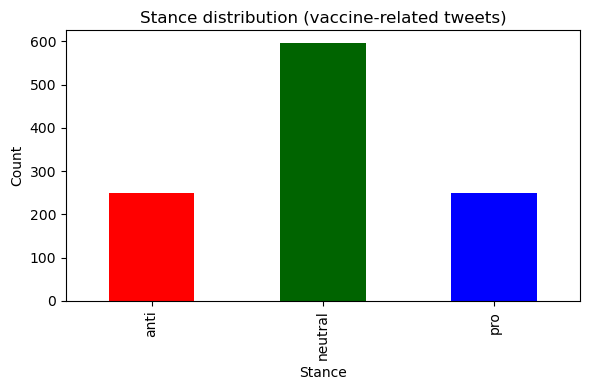

In [4]:
stance_counts = vaccine_tweets["stance"].value_counts().sort_index()

# Map stance → color
color_map = {
    "anti": "red",
    "neutral": "darkgreen",
    "pro": "blue",
}

# Build a color list in the same order as the index of stance_counts
colors = [color_map[s] for s in stance_counts.index]

plt.figure(figsize=(6, 4))
stance_counts.plot(kind="bar", color=colors)
plt.title("Stance distribution (vaccine-related tweets)")
plt.xlabel("Stance")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Pull Reddit posts about vaccines

We'll use the Reddit API via `praw`:

- Authenticate using credentials set as environment variables:
  - `REDDIT_CLIENT_ID`
  - `REDDIT_CLIENT_SECRET`
  - `REDDIT_USER_AGENT`
- Query vaccine/health-related subreddits for posts containing "vaccine".
- Store key fields in the `reddit_posts` table.

> **In order to run this code, one must:**  
> - Create a Reddit app (script) at https://www.reddit.com/prefs/apps  
> - Set the three environment variables above in your environment or Jupyter kernel.

The subreddits we could look at in the future are: 

- Pro-leaning: r/medicine, r/AskDocs
- Neutral-leaning: r/AskVet, r/Coronavirus, r/COVID19
- Anti-leaning: r/conspiracy, r/IntellectualDarkWeb

### Helper: Configure Reddit API client using environment variables.

This pattern keeps secrets out of the notebook.

In [5]:
def init_reddit_client(config_path="reddit_info.txt"):
    """
    Initialize a Reddit API client using credentials stored in a local text file.

    Expected file format (CSV with a header row), e.g.:

        client_id,client_secret,user_agent,user_name,password
        <your_client_id>,<your_client_secret>,<your_user_agent>,<your_username>,<your_password>

    Parameters
    ----------
    config_path : str or Path
        Path to the credentials file.

    Returns
    -------
    praw.Reddit or None
        Authenticated Reddit client, or None if initialization fails.
    """
    config_path = Path(config_path)

    # Basic existence check
    if not config_path.exists():
        print(f"[init_reddit_client] Config file not found at: {config_path}")
        print("Make sure reddit_info.txt is in the working directory or pass the correct path.")
        return None

    # Read the first (and presumably only) line of actual credentials after the header
    with config_path.open("r", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        try:
            row = next(reader)
        except StopIteration:
            print(f"[init_reddit_client] Config file {config_path} is empty or has no data rows.")
            return None

    # Extract required fields and strip whitespace
    client_id     = (row.get("client_id") or "").strip()
    client_secret = (row.get("client_secret") or "").strip()
    user_agent    = (row.get("user_agent") or "").strip()
    username      = (row.get("user_name") or "").strip()
    password      = (row.get("password") or "").strip()

    # Sanity check for required fields
    if not (client_id and client_secret and user_agent):
        print("[init_reddit_client] Missing one or more required fields: client_id, client_secret, user_agent.")
        print("Check the header and first data row in your reddit_info.txt.")
        return None

    # Build kwargs for praw.Reddit
    reddit_kwargs = {
        "client_id": client_id,
        "client_secret": client_secret,
        "user_agent": user_agent,
    }

    # Username/password are optional; if present, use script-style auth
    if username and password:
        reddit_kwargs.update({
            "username": username,
            "password": password,
        })

    # Initialize the client
    reddit = praw.Reddit(**reddit_kwargs)

    # Optional: simple check that auth is working (won't make a network call yet)
    print("[init_reddit_client] Reddit client initialized.")
    return reddit

In [6]:
reddit = init_reddit_client()
reddit

[init_reddit_client] Reddit client initialized.


### Define function to fetch Reddit posts

In [10]:
def fetch_reddit_posts(
    reddit_client,
    subreddits,
    keywords = None,
    limit_per_sub = 1000,
):
    """
    Fetch posts from a list of subreddits containing a search query (default "vaccine").
    
    Parameters
    ----------
    reddit_client : praw.Reddit
        Authenticated Reddit client.
    subreddits : list of str
        List of subreddit names (without 'r/').
    keywords : list of str
        Search query, e.g., "vaccine".
    limit_per_sub : int
        Max number of posts to fetch per subreddit.
    
    Returns
    -------
    pd.DataFrame
        DataFrame with one row per post.
    """
    
    if reddit_client is None:
        print("Reddit client is None; returning empty DataFrame.")
        return pd.DataFrame()

    if keywords is None:
        keywords = ["covid", "vaccine", "vaccination", "booster"]

    pattern = re.compile("|".join(re.escape(k.lower()) for k in keywords), re.IGNORECASE)
    all_posts = []

    for sub in subreddits:
        print(f"Collecting from r/{sub} ...")
        subreddit = reddit_client.subreddit(sub)

        collected = 0
        # *** This is exactly what that thread is talking about ***
        for submission in subreddit.new(limit=None):  # ~1000 max from listing
            title = submission.title or ""
            body = submission.selftext or ""
            full_text = (title + "\n\n" + body).strip()

            if pattern.search(full_text.lower()):
                all_posts.append({
                    "reddit_id": submission.id,
                    "subreddit": sub,
                    "title": title,
                    "selftext": body,
                    "full_text": full_text,
                    "created_utc": submission.created_utc,
                    "created_at": datetime.utcfromtimestamp(submission.created_utc).isoformat(),
                    "score": submission.score,
                    "num_comments": submission.num_comments,
                    "url": submission.url,
                })
                collected += 1
                if collected >= limit_per_sub:
                    break

        print(f"  Collected {collected} posts from r/{sub}.")

    df = pd.DataFrame(all_posts).drop_duplicates(subset=["reddit_id"])
    print(f"Total unique Reddit posts collected: {len(df)}")
    return df

### Fetch Reddit posts and create reddit_posts table

Choose a couple/several health/vaccine-related subreddits.

We're only going to look at a view subreddits, some which presumably lean pro-vaccination, and some which presumably leans anti-vaccination, and some that are presumably neutral-leaning.

- Pro-leaning: r/medicine, r/AskDocs
- Neutral-leaning: r/AskVet, r/Coronavirus, r/COVID19
- Anti-leaning: r/conspiracy, r/IntellectualDarkWeb

In [12]:
%%time

target_subreddits = ["medicine", "AskDocs", "AskVet", "Coronavirus", "COVID19", "conspiracy", "IntellectualDarkWeb"]

covid_core_keywords = [
    "covid",
    "covid19",
    "covid-19",
    "covid 19",
    "corona",
    "coronavirus",
    "ncov",
    "2019-ncov",
    "ncov-2019",
    "sars-cov",
    "sars cov",
    "sars-cov-2",
    "sars cov 2",
]

covid_geo_and_nicknames = [
    "wuhan virus",
    "wuhan flu",
    "wuhan coronavirus",
    "china virus",
    "chinese virus",
    "china flu",
    "chinese flu",
    "bat flu",
    "bat virus",
    "wuflu",
    "wu flu",
    "winnie the flu",
    "kung flu",
    "the rona",
    "miss rona",
    "rona",
]

covid_keywords = covid_core_keywords + covid_geo_and_nicknames

reddit_posts_df = fetch_reddit_posts(reddit, 
                                     target_subreddits, 
                                     keywords = covid_keywords,
                                     #limit_per_sub = None
                                    )

  Collected 69 posts from r/medicine.
  Collected 28 posts from r/AskDocs.
  Collected 9 posts from r/AskVet.
  Collected 865 posts from r/Coronavirus.
  Collected 929 posts from r/COVID19.
  Collected 45 posts from r/conspiracy.
  Collected 36 posts from r/IntellectualDarkWeb.
Total unique Reddit posts collected: 1981
CPU times: total: 2.98 s
Wall time: 1min 23s


In [14]:
print(f"Number of posts collected: {len(reddit_posts_df)}")

reddit_posts_df.head()

Number of posts collected: 1981


,reddit_id,subreddit,title,selftext,full_text,created_utc,created_at,score,num_comments,url
0,1pdy2m2,medicine,A Threat to Evidence-Based Vaccine Policy and ...,Published last night: https://www.nejm.org/doi...,A Threat to Evidence-Based Vaccine Policy and ...,1.764849e+09,2025-12-04T11:52:21,163,16,https://www.reddit.com/r/medicine/comments/1pd...
1,1pdsgxs,medicine,Experts say top FDA official’s claim that Covi...,STAT article reporting pushback against CBER D...,Experts say top FDA official’s claim that Covi...,1.764828e+09,2025-12-04T06:04:54,62,3,https://www.reddit.com/r/medicine/comments/1pd...
2,1pdlulx,medicine,"Aid who investigated COVID vaccines, Tracy Høe...","Edit: I meant aide, not aid. Grrr\n\nhttps://w...","Aid who investigated COVID vaccines, Tracy Høe...",1.764809e+09,2025-12-04T00:44:18,39,5,https://www.reddit.com/r/medicine/comments/1pd...
3,1p9zttj,medicine,Prasad: “I remain open to vigorous discussions...,> “I remain open to vigorous discussions and d...,Prasad: “I remain open to vigorous discussions...,1.764450e+09,2025-11-29T21:06:54,163,64,https://www.reddit.com/r/medicine/comments/1p9...
4,1p9qol6,medicine,Dr. Prasad of the FDA says that COVID-19 vacci...,https://www.nytimes.com/2025/11/28/health/fda-...,Dr. Prasad of the FDA says that COVID-19 vacci...,1.764428e+09,2025-11-29T14:46:38,467,94,https://www.reddit.com/r/medicine/comments/1p9...


## Create SQLite database & schema

Now that we have some posts from Reddit, we'll:

1. Create a local SQLite database `toy.db`.
2. Create tables:
   - `tweets` for labeled vaccine tweets.
   - `reddit_posts` for scraped Reddit posts.
3. Insert the labeled tweet data.

**Note on timestamps:**  
The Hugging Face dataset does not include tweet creation times.  
For this toy example, we'll simulate a `created_at` series so that we can demonstrate 
what time-based queries would look like. If this were a real pipeline, we'd be
able to use the actual tweet timestamps from the Twitter API or from however/wherever the dataset originated.

### Create the database and insert the data

In [15]:
# Connect to (or create) the SQLite database
db_path = "toy.db"
conn = sqlite3.connect(db_path)

# Create the tweets table with a schema that allows future extension
with conn:
    conn.execute("""
        CREATE TABLE IF NOT EXISTS tweets (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            source_id TEXT,
            text TEXT,
            stance TEXT,
            platform TEXT,
            created_at TEXT
        )
    """)

In [16]:
# Since the twitter data has no dates, we will simulate some
# We'll just go with an evenly spaced set of dates over some 120-day window
num_rows = len(vaccine_tweets)
start_date = datetime(2025, 3, 1)
dates = [start_date + pd.Timedelta(days=int(i * 120 / max(num_rows - 1, 1)))
         for i in range(num_rows)]

vaccine_tweets["created_at"] = dates
vaccine_tweets["platform"] = "twitter"

# Format: tf + 4‑digit zero‑padded counter + "_" + 8‑hex‑char random string
# e.g. tf0001_a3f9c1b2
source_ids = [
    f"tf{idx+1:04d}_{secrets.token_hex(4)}"  # 4 bytes → 8 hex chars
    for idx in range(num_rows)
]
vaccine_tweets["source_id"] = source_ids

# Insert into the tweets table
vaccine_tweets_for_db = vaccine_tweets.rename(columns={"tweet": "text"})
vaccine_tweets_for_db[["source_id", "text", "stance", "platform", "created_at"]].to_sql(
    "tweets",
    conn,
    if_exists="append",
    index=False
)

# Verify insertion with a quick count
with conn:
    total_tweets_in_db = conn.execute("SELECT COUNT(*) FROM tweets").fetchone()[0]

print("Total tweets in DB:", total_tweets_in_db)

Total tweets in DB: 2192


In [17]:
# Creating cursor
cur = conn.cursor()

# Peek at the schema of tweets
top_tweets = pd.read_sql_query("SELECT * FROM tweets LIMIT 5;", conn)
top_tweets

# Closing the connection
#conn.close()

,id,source_id,text,stance,platform,created_at
0,1,tf0001_abefa669,Can't help but question the rapid development ...,anti,twitter,2025-03-01 00:00:00
1,2,tf0002_f76225ec,Just read an article about how the COVID vacci...,anti,twitter,2025-03-01 00:00:00
2,3,tf0003_3ed2dedf,The globalist agenda is strong with this vacci...,anti,twitter,2025-03-01 00:00:00
3,4,tf0004_5750819a,Don't be a sheep - they want to control the ma...,anti,twitter,2025-03-01 00:00:00
4,5,tf0005_b5b6e63b,Bill Gates has been talking about population c...,anti,twitter,2025-03-01 00:00:00


In [21]:
# Create the reddit_posts table in SQLite
with conn:
    conn.execute("DROP TABLE IF EXISTS reddit_posts;")
    conn.execute("""
        CREATE TABLE reddit_posts (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            reddit_id TEXT,
            subreddit TEXT,
            url TEXT,
            title TEXT,
            selftext TEXT,
            full_text TEXT,
            created_utc REAL,
            created_at TEXT,
            score INTEGER,
            num_comments INTEGER,
            predicted_stance TEXT
        )
    """)

In [23]:
# Insert scraped posts into reddit_posts table
if not reddit_posts_df.empty:
    reddit_posts_df.to_sql(
        "reddit_posts",
        conn,
        if_exists="append",
        index=False
    )
    print("Inserted Reddit posts into DB:", len(reddit_posts_df))
else:
    print("No Reddit posts fetched; reddit_posts table remains empty.")

Inserted Reddit posts into DB: 1981


In [25]:
# Check schema
for row in conn.execute("PRAGMA table_info(reddit_posts);"):
    print(row)

# Peek at the first few rows via pandas
pd.read_sql_query("SELECT * FROM reddit_posts LIMIT 5;", conn)

(0, 'id', 'INTEGER', 0, None, 1)
(1, 'reddit_id', 'TEXT', 0, None, 0)
(2, 'subreddit', 'TEXT', 0, None, 0)
(3, 'url', 'TEXT', 0, None, 0)
(4, 'title', 'TEXT', 0, None, 0)
(5, 'selftext', 'TEXT', 0, None, 0)
(6, 'full_text', 'TEXT', 0, None, 0)
(7, 'created_utc', 'REAL', 0, None, 0)
(8, 'created_at', 'TEXT', 0, None, 0)
(9, 'score', 'INTEGER', 0, None, 0)
(10, 'num_comments', 'INTEGER', 0, None, 0)
(11, 'predicted_stance', 'TEXT', 0, None, 0)


,id,reddit_id,subreddit,url,title,selftext,full_text,created_utc,created_at,score,num_comments,predicted_stance
0,1,1pdy2m2,medicine,https://www.reddit.com/r/medicine/comments/1pd...,A Threat to Evidence-Based Vaccine Policy and ...,Published last night: https://www.nejm.org/doi...,A Threat to Evidence-Based Vaccine Policy and ...,1.764849e+09,2025-12-04T11:52:21,163,16,None
1,2,1pdsgxs,medicine,https://www.reddit.com/r/medicine/comments/1pd...,Experts say top FDA official’s claim that Covi...,STAT article reporting pushback against CBER D...,Experts say top FDA official’s claim that Covi...,1.764828e+09,2025-12-04T06:04:54,62,3,None
2,3,1pdlulx,medicine,https://www.reddit.com/r/medicine/comments/1pd...,"Aid who investigated COVID vaccines, Tracy Høe...","Edit: I meant aide, not aid. Grrr\n\nhttps://w...","Aid who investigated COVID vaccines, Tracy Høe...",1.764809e+09,2025-12-04T00:44:18,39,5,None
3,4,1p9zttj,medicine,https://www.reddit.com/r/medicine/comments/1p9...,Prasad: “I remain open to vigorous discussions...,> “I remain open to vigorous discussions and d...,Prasad: “I remain open to vigorous discussions...,1.764450e+09,2025-11-29T21:06:54,163,64,None
4,5,1p9qol6,medicine,https://www.reddit.com/r/medicine/comments/1p9...,Dr. Prasad of the FDA says that COVID-19 vacci...,https://www.nytimes.com/2025/11/28/health/fda-...,Dr. Prasad of the FDA says that COVID-19 vacci...,1.764428e+09,2025-11-29T14:46:38,467,94,None


## SQL queries: counts by stance, subreddits, keywords

Now that we have:

- Labeled vaccine tweets in `tweets`.
- Reddit posts in `reddit_posts`.

We can:

1. Count tweets by stance (now via SQL).
2. Count Reddit posts per subreddit.
3. Demonstrate queries that *would* use time and keyword filters.

Later, once stance predictions for Reddit posts are available, we'll also run:
- Counts by **predicted stance** and **subreddit**.

In [26]:
# Count labeled tweets by stance (SQL)
with conn:
    for row in conn.execute("""
        SELECT stance, COUNT(*) 
        FROM tweets 
        GROUP BY stance
        ORDER BY stance;
    """):
        print(row)

('anti', 500)
('neutral', 1192)
('pro', 500)


In [27]:
# Count Reddit posts by subreddit
with conn:
    rows = conn.execute("""
        SELECT subreddit, COUNT(*) 
        FROM reddit_posts 
        GROUP BY subreddit
        ORDER BY COUNT(*) DESC;
    """).fetchall()

if rows:
    print("\nReddit posts per subreddit:")
    for row in rows:
        print(row)
else:
    print("\nNo Reddit posts in DB yet.")


Reddit posts per subreddit:
('COVID19', 929)
('Coronavirus', 865)
('medicine', 69)
('conspiracy', 45)
('IntellectualDarkWeb', 36)
('AskDocs', 28)
('AskVet', 9)


safe           61
booster        44
Moderna        16
mandate        15
Pfizer          9
side effect     8
unsafe          1
dtype: int64


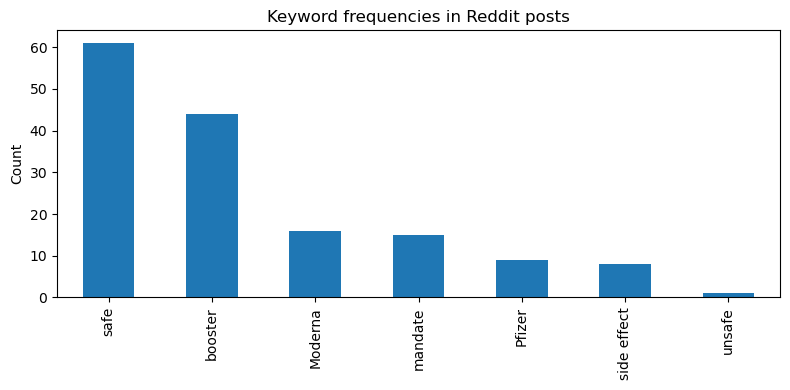

In [28]:
# Simple keyword frequency analysis for Reddit posts

KEYWORDS = ["mandate", "side effect", "safe", "unsafe", "booster", "Pfizer", "Moderna"]

# Pull full_text from DB into a DataFrame
reddit_posts_from_db = pd.read_sql_query("SELECT * FROM reddit_posts;", conn)

if reddit_posts_from_db.empty:
    print("No Reddit posts available for keyword analysis.")
else:
    keyword_counts = {kw: 0 for kw in KEYWORDS}
    for text in reddit_posts_from_db["full_text"].fillna(""):
        lower_text = text.lower()
        for kw in KEYWORDS:
            if kw.lower() in lower_text:
                keyword_counts[kw] += 1

    keyword_counts_series = pd.Series(keyword_counts).sort_values(ascending=False)
    print(keyword_counts_series)

    # Plot keyword frequencies
    plt.figure(figsize=(8, 4))
    keyword_counts_series.plot(kind="bar")
    plt.title("Keyword frequencies in Reddit posts")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

BELOW:

The stacked bar chart for tweets shows which COVID‑related terms are more associated with pro vs anti vs neutral stances; 
the analogous Reddit chart shows which subreddits tend to use which terms. This is a simple but interpretable lens on how different communities talk about COVID and vaccines.

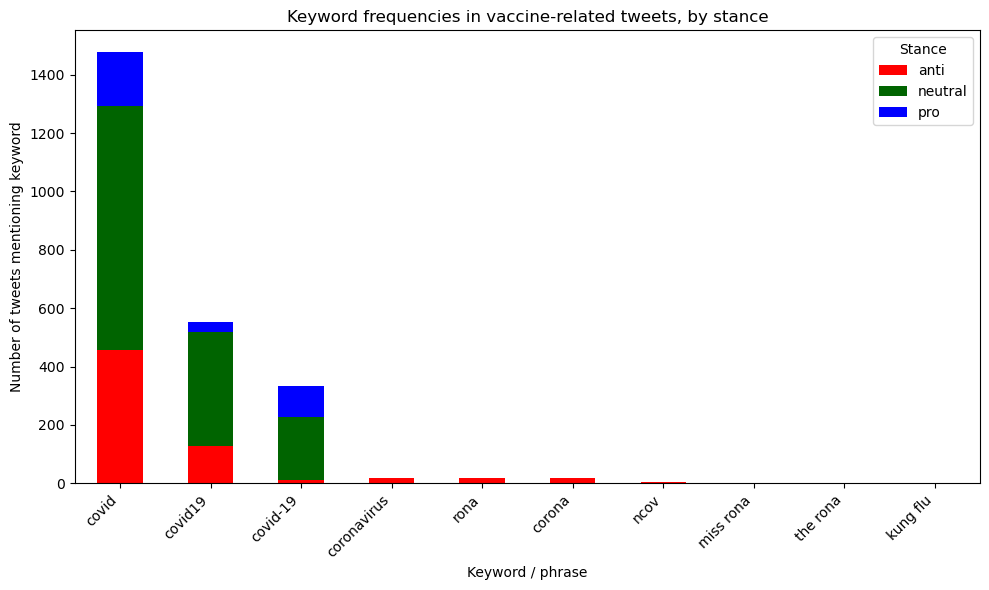

In [41]:
# Use the keywords previously defined
KEYWORDS = covid_core_keywords + covid_geo_and_nicknames

# Load tweet text + stance from DB
tweets_df = pd.read_sql_query("SELECT text, stance FROM tweets;", conn)

if tweets_df.empty:
    print("No tweets in DB for keyword-by-stance analysis.")
else:
    # We’ll use these stances in this order
    stances = ["anti", "neutral", "pro"]

    # Initialize counts: rows = keywords, cols = stances
    tweet_kw_counts = pd.DataFrame(0, index = KEYWORDS, columns = stances)

    # Count: for each tweet, for each keyword, increment the stance bucket if keyword is present
    for row in tweets_df.itertuples(index = False):
        text = (row.text or "").lower()
        stance = row.stance
        if stance not in stances:
            continue  # skip unexpected labels

        for kw in KEYWORDS:
            if kw.lower() in text:
                tweet_kw_counts.loc[kw, stance] += 1

    # Sort by total frequency and keep top N for readability
    tweet_kw_counts["total"] = tweet_kw_counts.sum(axis=1)
    tweet_kw_counts_sorted = (
        tweet_kw_counts
        .sort_values("total", ascending=False)
        .drop(columns="total")
    )

    # For plotting, take top N keywords
    TOP_N = 10 
    tweet_kw_counts_sorted = tweet_kw_counts_sorted.head(TOP_N)

    # Color map by stance
    stance_colors = {
        "anti": "red",
        "neutral": "darkgreen",
        "pro": "blue",
    }
    bar_colors = [stance_colors[s] for s in tweet_kw_counts_sorted.columns]

    # Plot stacked bar chart
    plt.figure(figsize=(10, 6))
    tweet_kw_counts_sorted.plot(
        kind="bar",
        stacked=True,
        color=bar_colors,
        ax=plt.gca()
    )
    plt.title("Keyword frequencies in vaccine-related tweets, by stance")
    plt.xlabel("Keyword / phrase")
    plt.ylabel("Number of tweets mentioning keyword")
    plt.xticks(rotation = 45, ha = "right")
    plt.legend(title = "Stance")
    plt.tight_layout()
    plt.show()

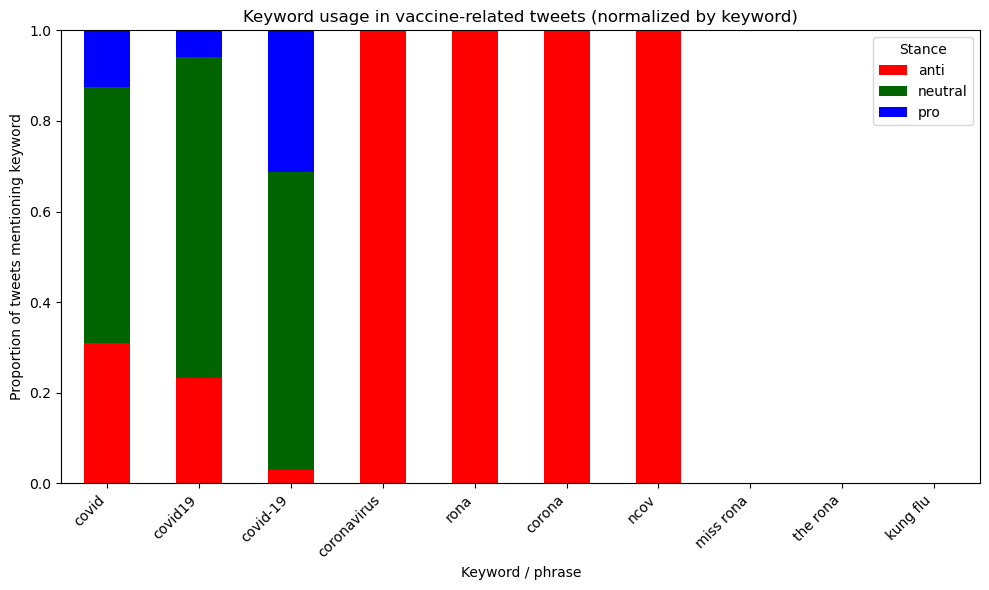

In [42]:
# Normalized version: for each keyword, show proportion of mentions by stance
tweet_kw_props = tweet_kw_counts_sorted.div(
    tweet_kw_counts_sorted.sum(axis=1),  # row-wise sum
    axis=0
).fillna(0.0)

plt.figure(figsize=(10, 6))
tweet_kw_props.plot(
    kind="bar",
    stacked=True,
    color=[stance_colors[s] for s in tweet_kw_props.columns],
    ax=plt.gca()
)
plt.title("Keyword usage in vaccine-related tweets (normalized by keyword)")
plt.xlabel("Keyword / phrase")
plt.ylabel("Proportion of tweets mentioning keyword")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Stance")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

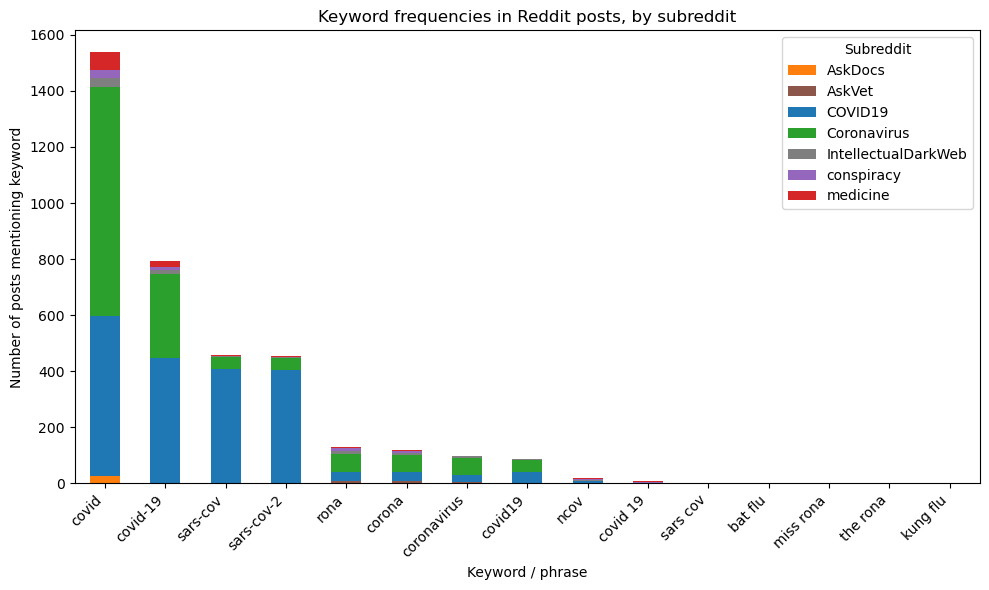

In [43]:
# Load Reddit posts from DB
reddit_df = pd.read_sql_query("SELECT full_text, subreddit FROM reddit_posts;", conn)

if reddit_df.empty:
    print("No Reddit posts in DB for keyword-by-subreddit analysis.")
else:
    # Get the list of subreddits present
    subreddits = sorted(reddit_df["subreddit"].dropna().unique().tolist())

    # Initialize counts: rows = keywords, cols = subreddits
    reddit_kw_counts = pd.DataFrame(0, index=KEYWORDS, columns=subreddits)

    for row in reddit_df.itertuples(index=False):
        text = (row.full_text or "").lower()
        sub = row.subreddit
        if sub not in subreddits:
            continue

        for kw in KEYWORDS:
            if kw.lower() in text:
                reddit_kw_counts.loc[kw, sub] += 1

    # Sort by total frequency and keep top N for readability
    reddit_kw_counts["total"] = reddit_kw_counts.sum(axis=1)
    reddit_kw_counts_sorted = (
        reddit_kw_counts
        .sort_values("total", ascending=False)
        .drop(columns="total")
    )

    TOP_N = 15
    reddit_kw_counts_sorted = reddit_kw_counts_sorted.head(TOP_N)

    # Pick colors for each subreddit
    subreddit_colors = {}
    if set(subreddits) == {"medicine", "AskDocs", "AskVet", "Coronavirus", "COVID19", "conspiracy", "IntellectualDarkWeb"}:
        subreddit_colors = {
            "medicine": "tab:red",
            "AskDocs": "tab:orange",
            "AskVet": "tab:brown",
            "Coronavirus": "tab:green",
            "COVID19": "tab:blue",
            "conspiracy": "tab:purple",
            "IntellectualDarkWeb": "tab:grey",
        }
    else:
        # Fallback: use matplotlib's default color cycle
        default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
        subreddit_colors = {
            sub: default_colors[i % len(default_colors)]
            for i, sub in enumerate(reddit_kw_counts_sorted.columns)
        }

    bar_colors_reddit = [subreddit_colors[s] for s in reddit_kw_counts_sorted.columns]

    # Plot stacked bar chart
    plt.figure(figsize=(10, 6))
    reddit_kw_counts_sorted.plot(
        kind="bar",
        stacked=True,
        color=bar_colors_reddit,
        ax=plt.gca()
    )
    plt.title("Keyword frequencies in Reddit posts, by subreddit")
    plt.xlabel("Keyword / phrase")
    plt.ylabel("Number of posts mentioning keyword")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Subreddit")
    plt.tight_layout()
    plt.show()

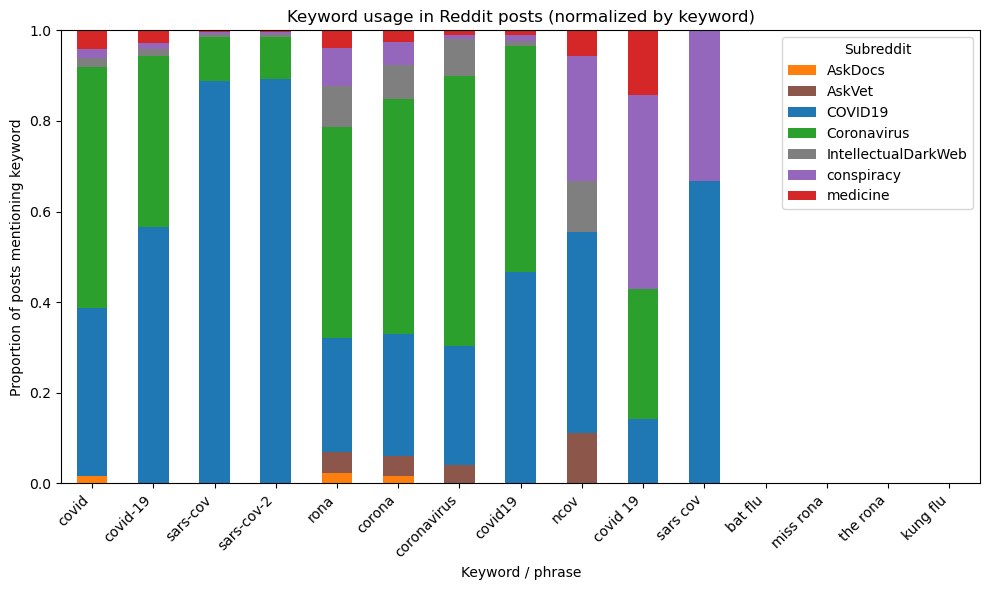

In [44]:
# Normalized version: for each keyword, show proportion of mentions by subreddit
reddit_kw_props = reddit_kw_counts_sorted.div(
    reddit_kw_counts_sorted.sum(axis=1),
    axis=0
).fillna(0.0)

plt.figure(figsize=(10, 6))
reddit_kw_props.plot(
    kind="bar",
    stacked=True,
    color=[subreddit_colors[s] for s in reddit_kw_props.columns],
    ax=plt.gca()
)
plt.title("Keyword usage in Reddit posts (normalized by keyword)")
plt.xlabel("Keyword / phrase")
plt.ylabel("Proportion of posts mentioning keyword")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Subreddit")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

## Stance classification on vaccine tweets (model comparison)

We now train a set of **traditional machine learning classifiers** on the labeled
vaccine-related tweets.

To keep the representation simple and interpretable, we use:

- **Features:** unigram and bigram TF–IDF (n‑gram range 1–4), which already capture many
  short phrases and slogans. In practice, we could extend this to longer n‑grams or
  character n‑grams to pick up more nuanced or creative language.

- **Task:** multi‑class stance classification with labels  
  `stance ∈ {pro, anti, neutral}`.

We compare several supervised models trained on the same TF–IDF features:

- `LogisticRegression` (multinomial)
- `LinearSVC` (linear SVM)
- `MultinomialNB`
- `MLPClassifier` (small feedforward neural network)
- `RandomForestClassifier`
- `GradientBoostingClassifier`

For each model we:

1. Split the tweet data into train / test sets.
2. Fit the model on the training TF–IDF features.
3. Evaluate on the held-out test set using:
   - `accuracy_score`
   - `f1_score` (macro-averaged, to balance the three stance classes)
   - `classification_report` and `confusion_matrix` for the best model.
4. For linear models, inspect the highest‑weight unigrams/bigrams per stance as a way to
   understand the language each stance relies on.

We then select the best-performing model and use it as our **cross-platform stance classifier**
on Reddit posts, updating the `predicted_stance` column in the `reddit_posts` table and using
those predictions in the downstream visualizations.

### TF–IDF and train/test split

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
)

# Let's go ahead and pull the tweets from the DB again
tweets_df = pd.read_sql_query("SELECT text AS tweet, stance FROM tweets;", conn)

# Prepare inputs and labels
X = tweets_df["tweet"].fillna("").astype(str).values
y = tweets_df["stance"].astype(str).values

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y,
)

print("Train size:", len(X_train), "Test size:", len(X_test))

# TF–IDF with unigrams + bigrams + trigrams + 4grams
tfidf = TfidfVectorizer(
    ngram_range = (1, 4),
    min_df = 3,
    max_df = 0.9,
    stop_words="english",
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

Train size: 1753 Test size: 439


### Define models and compare them

In [67]:
%%time

models = {
    "log_reg": LogisticRegression(
        max_iter=1000,
        multi_class="multinomial",
        n_jobs=-1,
    ),
    "linear_svc": LinearSVC(),
    "multinomial_nb": MultinomialNB(),
    "mlp": MLPClassifier(
        hidden_layer_sizes=(100,),
        max_iter=300,
        random_state=RANDOM_SEED,
    ),
    "random_forest": RandomForestClassifier(
        n_estimators=200,
        random_state=RANDOM_SEED,
        n_jobs=-1,
    ),
    "gradient_boosting": GradientBoostingClassifier(
        random_state=RANDOM_SEED,
    ),
}

results = []

for name, clf in models.items():
    print(f"\n=== Training {name} ===")
    clf.fit(X_train_tfidf, y_train)
    y_pred = clf.predict(X_test_tfidf)

    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")

    results.append({
        "model": name,
        "accuracy": acc,
        "f1_macro": f1_macro,
    })

results_df = pd.DataFrame(results).sort_values("f1_macro", ascending=False)

results_df


=== Training log_reg ===

=== Training linear_svc ===

=== Training multinomial_nb ===

=== Training mlp ===

=== Training random_forest ===

=== Training gradient_boosting ===
CPU times: total: 8.78 s
Wall time: 11.2 s


,model,accuracy,f1_macro
3,mlp,0.990888,0.988696
1,linear_svc,0.986333,0.983984
2,multinomial_nb,0.984055,0.982381
4,random_forest,0.981777,0.981298
0,log_reg,0.979499,0.978668
5,gradient_boosting,0.974943,0.972012


### Inspect the best model + simple ROC for “anti vs rest”

Let's go ahead and pick the best by macro‑F1 and then check the classification report + confusion matrix:

In [68]:
best_row = results_df.iloc[0]
best_name = best_row["model"]
best_model = models[best_name]

print(f"\nBest model by macro-F1: {best_name}")
print(best_row)


Best model by macro-F1: mlp
model            mlp
accuracy    0.990888
f1_macro    0.988696
Name: 3, dtype: object



Classification report (best model):
              precision    recall  f1-score   support

        anti       1.00      0.98      0.99       100
     neutral       1.00      0.99      1.00       239
         pro       0.96      1.00      0.98       100

    accuracy                           0.99       439
   macro avg       0.99      0.99      0.99       439
weighted avg       0.99      0.99      0.99       439

              pred_pro  pred_neutral  pred_anti
true_pro           100             0          0
true_neutral         2           237          0
true_anti            2             0         98


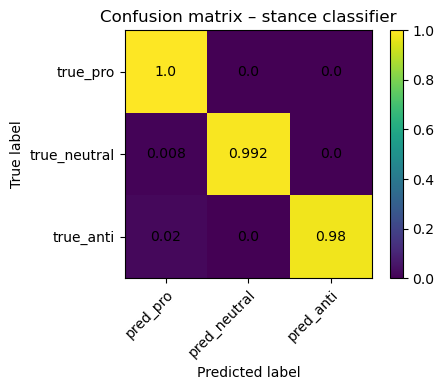

In [69]:
y_pred_best = best_model.predict(X_test_tfidf)

print("\nClassification report (best model):")
print(classification_report(y_test, y_pred_best))

cm = confusion_matrix(y_test, y_pred_best, labels=["pro", "neutral", "anti"])
cm_df = pd.DataFrame(
    cm,
    index=["true_pro", "true_neutral", "true_anti"],
    columns=["pred_pro", "pred_neutral", "pred_anti"],
)
print(cm_df)

cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
cm_norm_rounded = np.round(cm_norm, 3)

fig, ax = plt.subplots(figsize=(5, 4))

# Show the confusion matrix as an image
im = ax.imshow(cm_norm_rounded)

# Set tick marks and labels
ax.set_xticks(np.arange(len(["pred_pro", "pred_neutral", "pred_anti"])))
ax.set_yticks(np.arange(len(["true_pro", "true_neutral", "true_anti"])))
ax.set_xticklabels(["pred_pro", "pred_neutral", "pred_anti"])
ax.set_yticklabels(["true_pro", "true_neutral", "true_anti"])

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Confusion matrix – stance classifier")

# Rotate x‑tick labels for readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Annotate each cell with the count
for i in range(cm_norm_rounded.shape[0]):
    for j in range(cm_norm_rounded.shape[1]):
        ax.text(
            j,
            i,
            cm_norm_rounded[i, j],
            ha="center",
            va="center",
        )

# Add a colorbar and tighten layout
fig.colorbar(im, ax=ax)
fig.tight_layout()
plt.show()

### ROC/AUC

Since ROC is fundamentally binary, we can go ahead and just collapse it to “anti vs rest”...

In [70]:
# Binary labels: 1 = anti, 0 = not-anti
y_test_binary = (y_test == "anti").astype(int)

# Need decision_function or predict_proba; fall back appropriately
if hasattr(best_model, "decision_function"):
    scores = best_model.decision_function(X_test_tfidf)
    # For multi-class, we take the "anti" column; for binary, it’s a 1-D array
    if scores.ndim > 1:
        # Acquire column for 'anti'
        class_idx = np.where(best_model.classes_ == "anti")[0][0]
        scores = scores[:, class_idx]
elif hasattr(best_model, "predict_proba"):
    proba = best_model.predict_proba(X_test_tfidf)
    class_idx = np.where(best_model.classes_ == "anti")[0][0]
    scores = proba[:, class_idx]
else:
    scores = None

if scores is not None:
    fpr, tpr, thresholds = roc_curve(y_test_binary, scores)
    auc_val = roc_auc_score(y_test_binary, scores)
    print(f"\nROC AUC for 'anti' vs rest (best model): {auc_val:.3f}")
else:
    print("\nBest model does not expose scores for ROC/AUC.")


ROC AUC for 'anti' vs rest (best model): 1.000


ROC AUC for 'anti' vs rest (best model): 1.000


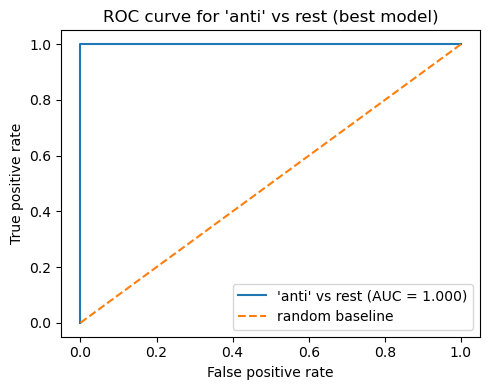

In [71]:
# Binary labels: 1 = anti, 0 = not-anti
y_test_binary = (y_test == "anti").astype(int)

# Get scores for ROC/AUC
scores = None

if hasattr(best_model, "decision_function"):
    raw_scores = best_model.decision_function(X_test_tfidf)
    # If multi-class, pick the column corresponding to "anti"
    if raw_scores.ndim > 1:
        class_idx = np.where(best_model.classes_ == "anti")[0][0]
        scores = raw_scores[:, class_idx]
    else:
        scores = raw_scores
elif hasattr(best_model, "predict_proba"):
    proba = best_model.predict_proba(X_test_tfidf)
    class_idx = np.where(best_model.classes_ == "anti")[0][0]
    scores = proba[:, class_idx]

if scores is not None:
    fpr, tpr, thresholds = roc_curve(y_test_binary, scores)
    auc_val = roc_auc_score(y_test_binary, scores)
    print(f"ROC AUC for 'anti' vs rest (best model): {auc_val:.3f}")

    # Plot ROC curve
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.plot(fpr, tpr, label=f"'anti' vs rest (AUC = {auc_val:.3f})")
    # Random baseline
    ax.plot([0, 1], [0, 1], linestyle="--", label="random baseline")

    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
    ax.set_title("ROC curve for 'anti' vs rest (best model)")
    ax.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
else:
    print("Best model does not expose scores suitable for ROC/AUC.")

### Inspect top n‑grams for discourse sense

We're doing this for a linear model. Sure, the best model is non‑linear, but we can still run this for one of the linear ones as an “interpretability side‑view”. 
Also the accuracy for all the models were quite high, so this will give us good insight anyways.

In [75]:
def show_top_ngrams_for_linear_model(clf, vectorizer, class_labels,
                                     top_n=15, min_words=1, max_words=None):
    """
    For a linear classifier with coef_ (e.g., LogisticRegression, LinearSVC),
    print the top positive-weight n-grams for each class.

    Parameters
    ----------
    clf : fitted linear model with coef_
    vectorizer : fitted TfidfVectorizer
    class_labels : list/array of class labels, aligned with clf.coef_
    top_n : int, number of n-grams to show per class
    min_words : int, minimum number of tokens in n-gram (e.g. 2 to skip unigrams)
    max_words : int or None, maximum number of tokens in n-gram (e.g. 3 for up to trigrams)
    """

    # Handle both old and new scikit-learn APIs
    try:
        feature_names = vectorizer.get_feature_names_out()
    except AttributeError:
        feature_names = vectorizer.get_feature_names()

    feature_names = np.array(feature_names)

    # Count how many words each n-gram has
    ngram_lengths = np.array([len(t.split()) for t in feature_names])

    # Build mask for desired n-gram lengths
    mask = ngram_lengths >= min_words
    if max_words is not None:
        mask &= (ngram_lengths <= max_words)

    valid_indices = np.where(mask)[0]

    coefs = clf.coef_

    for idx, label in enumerate(class_labels):
        coef = coefs[idx]

        # Filter coefficients to only the desired n-grams
        coef_filtered = coef[valid_indices]
        top_local_idx = np.argsort(coef_filtered)[-top_n:]
        top_feature_indices = valid_indices[top_local_idx]

        print(f"\nTop {top_n} n-grams for class '{label}' "
              f"(length {min_words}–{max_words or 'max'} words):")
        for j in reversed(top_feature_indices):
            print(f"  {feature_names[j]}")

Even though the MLP classifier achieves the highest macro F1 and accuracy,
the linear models (logistic regression/linear SVM) are much easier to
interpret. Here I inspect the highest-weight unigrams and bigrams per stance
for logistic regression. This provides a quick window into the language patterns
associated with pro/anti/neutral vaccine stances.

In [77]:
# Use logistic regression for interpretability side-view,
# even though MLP is the best by F1/accuracy.
log_reg = models["log_reg"]  # already trained

# Show top 2–3-grams (skip unigrams)
show_top_ngrams_for_linear_model(
    log_reg,
    tfidf,
    class_labels=log_reg.classes_,
    top_n=15,
    min_words=2,
    max_words=4,
)


Top 15 n-grams for class 'anti' (length 2–4 words):
  covid vaccine
  don let
  vaccine covid19
  control masses
  coronavirus vaccine
  just way
  big pharma
  pushing vaccine
  sounds like
  just beginning
  got sick
  forced vaccinations
  vaccine passports
  vaccine effects
  say covid

Top 15 n-grams for class 'neutral' (length 2–4 words):
  covid19vaccine vaccineswork
  make sure
  don forget
  covid19 vaccineswork
  mental health
  covid 19
  healthcare workers
  support local
  challenging times
  let remember
  wearing masks
  protection covid19
  protect covid19
  stay connected
  covid19 staysafe

Top 15 n-grams for class 'pro' (length 2–4 words):
  vaccines control
  control virus
  best shot
  let trust
  end pandemic
  covid 19
  vaccine safety
  vaccine protect vaccineequity
  protect vaccineequity
  vaccines don
  covid 19 vaccine testament
  19 vaccine testament
  vaccine testament
  protection control
  vaccines aren


## Apply the best model to Reddit and update predicted_stance

In [79]:
# Load Reddit posts from DB
reddit_posts = pd.read_sql_query("SELECT * FROM reddit_posts;", conn)

if reddit_posts.empty:
    print("No Reddit posts available for stance prediction.")
else:
    reddit_texts = reddit_posts["full_text"].fillna("").astype(str).values
    reddit_tfidf = tfidf.transform(reddit_texts)

    reddit_pred = best_model.predict(reddit_tfidf)
    reddit_posts["predicted_stance"] = reddit_pred

    # Overwrite the reddit_posts table with updated predictions
    with conn:
        conn.execute("DELETE FROM reddit_posts;")
    reddit_posts.to_sql("reddit_posts", conn, if_exists="append", index=False)

    print("Updated reddit_posts table with predicted_stance using best model.")
    print(reddit_posts["predicted_stance"].value_counts())

Updated reddit_posts table with predicted_stance using best model.
predicted_stance
neutral    934
pro        567
anti       480
Name: count, dtype: int64


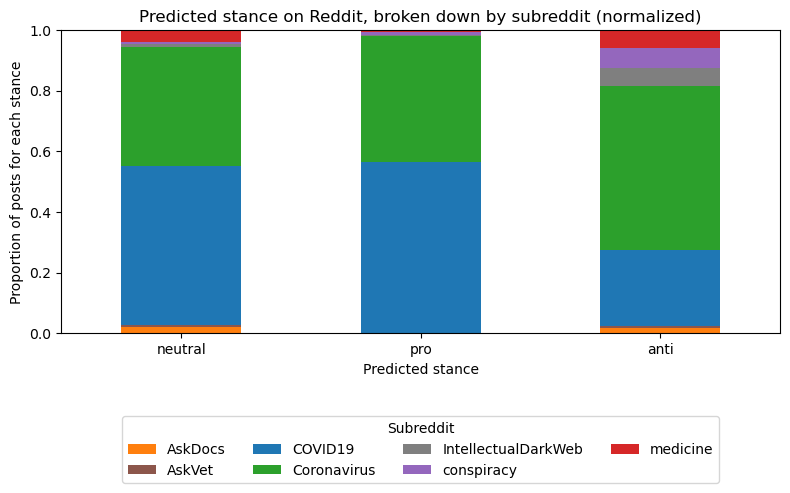

In [80]:
# Reload just what we need from the DB
reddit_df = pd.read_sql_query(
    "SELECT subreddit, predicted_stance FROM reddit_posts;",
    conn
)

if reddit_df.empty:
    print("No Reddit posts in DB for stance-by-subreddit analysis.")
else:
    # Ensure we know which stances and subreddits we're working with
    stances = ["neutral", "pro", "anti"]
    subreddits = sorted(reddit_df["subreddit"].dropna().unique().tolist())

    # Crosstab: counts of posts per (stance, subreddit)
    ct = pd.crosstab(reddit_df["predicted_stance"], reddit_df["subreddit"])

    # Reindex rows in desired stance order
    ct = ct.reindex(stances)

    # Normalized version: for each stance, proportion of posts from each subreddit
    ct_norm = ct.div(ct.sum(axis=1), axis=0).fillna(0.0)

    # Build color map for subreddits (reuse earlier scheme if it matches)
    if set(subreddits) == {
        "medicine", "AskDocs", "AskVet", "Coronavirus",
        "COVID19", "conspiracy", "IntellectualDarkWeb"
    }:
        subreddit_colors = {
            "medicine": "tab:red",
            "AskDocs": "tab:orange",
            "AskVet": "tab:brown",
            "Coronavirus": "tab:green",
            "COVID19": "tab:blue",
            "conspiracy": "tab:purple",
            "IntellectualDarkWeb": "tab:grey",
        }
    else:
        default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
        subreddit_colors = {
            sub: default_colors[i % len(default_colors)]
            for i, sub in enumerate(ct_norm.columns)
        }

    bar_colors = [subreddit_colors[s] for s in ct_norm.columns]

    # Plot: 3 bars (neutral, pro, anti), stacked by subreddit proportions
    fig, ax = plt.subplots(figsize=(8, 5))
    ct_norm.plot(
        kind="bar",
        stacked=True,
        color=bar_colors,
        ax=ax,
    )

    ax.set_title("Predicted stance on Reddit, broken down by subreddit (normalized)")
    ax.set_xlabel("Predicted stance")
    ax.set_ylabel("Proportion of posts for each stance")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_ylim(0, 1)

    ax.legend(
        title="Subreddit",
        loc="upper center",
        bbox_to_anchor=(0.5, -0.25),
        ncol=min(len(ct_norm.columns), 4),
    )
    fig.subplots_adjust(bottom=0.30)
    plt.tight_layout()
    plt.show()

## Summary and reflections

This notebook builds a small but complete **cross-platform pipeline** for analyzing
vaccine discourse, using:

- A labeled, synthetic tweet dataset about a vaccine-related conspiracy theory, and
- Live Reddit posts from multiple health- and conspiracy-related subreddits.

### What we built

1. **ETL + storage**

   - Pulled a vaccine-conspiracy subset of the `webimmunization` tweet dataset and
     constructed a stance label (`pro` / `anti` / `neutral`) based on whether the tweet
     supports or denies the conspiracy.
   - Collected vaccine/COVID-related Reddit posts via the official API using a curated
     keyword list derived from richer regex patterns (e.g., `covid`, `coronavirus`,
     `wuhan virus`, various nicknames).
   - Stored both sources in a **SQLite database** with separate `tweets` and
     `reddit_posts` tables, including synthetic tweet IDs and timestamps for the
     Twitter side.

2. **Text representation**

   - Used **TF–IDF features** with n‑grams up to length 4  
     `ngram_range=(1, 4), min_df=3, max_df=0.9, stop_words="english"`.
   - This captures not just individual tokens but also short phrases like
     *“vaccine passports”*, *“big pharma”*, *“end pandemic”*, and other multi‑word
     constructions that are central to vaccine narratives.

3. **Model comparison on Twitter stance labels**

   - Trained and evaluated several standard supervised models on the labeled tweets:
     - `LogisticRegression`
     - `LinearSVC`
     - `MultinomialNB`
     - `MLPClassifier`
     - `RandomForestClassifier`
     - `GradientBoostingClassifier`
   - All models performed extremely well (macro F1 ≈ 0.97–0.99), with a small
     multi-layer perceptron (`MLPClassifier`) achieving the best scores
     (accuracy ≈ 0.99, macro F1 ≈ 0.989).
   - The confusion matrix for the MLP is almost perfectly diagonal, and a binary
     ROC/AUC view for *“anti vs rest”* gives an AUC of ~1.0, indicating near-perfect
     separation on this dataset.

   These very strong numbers reflect important **properties of the training data**:

   - The tweet dataset is relatively **small** compared to real-world social
     media corpora.
   - It is also **LLM-generated/synthetic**, which likely makes the class
     boundaries cleaner and the language less noisy and less coded than what
     we would see in a fully natural, adversarial environment.
   - As a result, even relatively simple models can achieve very high performance.

4. **Interpretability via linear models and n‑grams**

   - Even though the MLP is the best-performing model, a **linear model**
     (logistic regression) still achieves very strong performance, and it exposes
     interpretable coefficients.
   - By re-using the TF–IDF vectorizer and inspecting the highest-weight
     n‑grams (2–4 words) per stance, we surfaced phrases such as:
     - Anti: terms around *“vaccine passports”*, *“big pharma”*, *“forced
       vaccinations”*, etc.
     - Neutral: more informational / supportive phrases like
       *“healthcare workers”*, *“challenging times”*, *“stay connected”*.
     - Pro: phrases like *“end pandemic”*, *“let trust [science]”*,
       *“vaccine safety”*.
   - This shows how classic linear models can double as simple, explainable
     discourse lenses even when a non-linear model is used for final prediction.

5. **Cross-platform transfer to Reddit**

   - Applied the best-performing model (MLP) to Reddit posts using the same
     TF–IDF representation (with up to 4‑grams).
   - Updated the `predicted_stance` column in `reddit_posts` and examined the
     distribution of predictions:
     - In one run, for example, approximately:
       - 934 posts labeled as **neutral**
       - 567 as **pro**
       - 480 as **anti**
   - Built **normalized stacked bar charts** to show:
     - For each **keyword**, how usage breaks down by stance and by subreddit.
     - For each **stance**, how the posts are distributed across subreddits.

   This provides a coarse but useful picture of which communities contribute
   disproportionately to different stances and which terms or nicknames they use.

### Limitations and what this demonstrates

- **Data realism and coverage**
  - The Twitter dataset is **synthetic and relatively small**, which explains the
    very clean separation and high scores. It likely under-represents vague, coded,
    or sarcastic language that is common in real-world vaccine discourse.
  - The Reddit sample, while drawn from live data, is limited to a handful of
    subreddits and a keyword-based filter, so it should be interpreted as a
    *toy corpus* rather than a comprehensive view of platform-wide discussion.

- **Modeling choices**
  - The best-performing model is **non-linear** (MLP), and we used that for
    cross-platform prediction.
  - At the same time, a **linear model** (logistic regression / linear SVM)
    achieves very similar performance and offers straightforward interpretability.
    In a high-stakes setting, one could reasonably choose the linear model
    for its transparency, especially if performance differences are marginal.

- **Scope**
  - The pipeline focuses purely on **textual features** (TF–IDF n‑grams). It does
    not incorporate user-level, network-level, or temporal features, which would be
    crucial for serious work on coordinated campaigns, misinformation, or fraud.
  - The stance predictions on Reddit should be viewed as a **first-pass triage
    signal** to surface posts and narratives for further human review, not as
    definitive labels.

Overall, this notebook demonstrates:

- End-to-end **ETL** from public sources (Hugging Face + Reddit API) into a SQL database.
- Use of **classic and neural models** for supervised classification, including
  evaluation with accuracy, macro F1, confusion matrices, and ROC/AUC.
- Practical **NLP feature engineering** (n‑grams, keyword lists, regex-inspired
  filters) and basic unsupervised/topic tools.
- The ability to **communicate strengths and limitations** of the resulting models
  and data, which is critical for applying analytics to real-world investigations
  in a public-interest context.